# **DATA PROFILING**

## Objectives

* Take a closer look at data. Understand data types, distribution, gaps (i.e. missing values).
## Inputs

* Raw data (house_prices_records.csv)

## Outputs

* One cleaned dataset of house_prices_records that is ready for Exploratory Data Analysis.

## Additional Comments

* In the Data Collection phase, we inspected inherited_houses.csv file manually. It was easy to do so because of only 4 raws of data. We concluded that the only difference from "house_prices_records.csv" is the absence of SalePrice. For the data cleaning purpose, we are only focusing primary dataset i.e. (house_price_records.csv), because inherited house dataset is (1) irrelavant for EDA and (2) complete and ready to use as it is.


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

---

# Data Profiling

## Schema validation

Check that data confirms to schema outlined in metadata

In [ ]:
# Make sure to work on a copy of data

import pandas as pd
df_source_data=pd.read_csv("inputs/datasets/raw/house_prices_records.csv")
df=df_source_data.copy()
df.head(5)

There are 24 columns. Column name description is provided in metadata for additional context. This can help determine data type.

## Data type conversion

This step is important so correct categorical variables are identified for profiling down the line.

In [57]:
cat_data_col=('BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual','OverallCond','OverallQual','YearBuilt','YearRemodAdd')

for cat in cat_data_col:
    df[cat]=df[cat].astype('category')

print(df.dtypes)

1stFlrSF            int64
2ndFlrSF          float64
BedroomAbvGr      float64
BsmtExposure     category
BsmtFinSF1          int64
BsmtFinType1     category
BsmtUnfSF           int64
EnclosedPorch     float64
GarageArea          int64
GarageFinish     category
GarageYrBlt       float64
GrLivArea           int64
KitchenQual      category
LotArea             int64
LotFrontage       float64
MasVnrArea        float64
OpenPorchSF         int64
OverallCond      category
OverallQual      category
TotalBsmtSF         int64
WoodDeckSF        float64
YearBuilt        category
YearRemodAdd     category
SalePrice           int64
dtype: object


## Run detailing profiling

In [ ]:
# Note : A copy of report is saved and provided down the line, to avoid re running cell again and again
from ydata_profiling import ProfileReport
profile = ProfileReport(df=df)
profile.to_notebook_iframe()

In [ ]:
profile.to_file(output_file='outputs/profiling_report_output.html')

## Primary Findings

**Variables**

- Therere are 24 variables in total. 16 Variables are numerical and 8 are categorical.

- All eight categorical variables are ordinal in nature. four of them are numerically encoded and four are not.
    - For analysis purpose YearBuilt and YearRemodAdd have been treated as categorical ordinal value. This will provide context for "an apartment build before year X.. or after year Y"

- All numerical variables conforms to min-max range provided in metadata.
    - However, there are no apartments where OverallCond = 10 (excellent)
    
- All categorical variable conforms to categories provided in metadata. 
    

#### Missing values and possible approaches

- ```SalePrice```which will be our target variable down the line, has zero missing values. Good news for analysis and prediction.

- ```EnclosedPorch``` and ```WoodDeckSF``` columns have about 90% data missing. Consider to drop them for analysis.

- ```LotFrontage```has 17.7 % missing values. However, it seems to be highly overall correlated with ```LotArea```, It also makes sense in physical world. Bigger the lot area, the higher the chances that LotFrontage (i.e. linear feet of street connected to property) is bigger. So, we can leverage this relation for missing data imputaion.

- ```GarageFinish```has 11.1% missing values. It seems to be highly correlated with ```GarageArea```. In phsyical world, they are independent. For example, a bigger garden does not nessarily mean high qality finish. So, we may have to look at other areas to find imputation strategies, for ex. distribution.

- ```BsmtFinType1```has 7.8% missing values. It seems to be highly correlated with ```BsmtExposure```. In physical world, "walkout or garden level walls exposure level" and "quality of basement" are independent. So, perhaps this correlation is just coinsidence. So, we may have to look at other strategies for data impuration, for ex. distribution.

- ```BedroomAbvGr```has 6.8% missing values. It seems to be highly correlated with ```2ndFlrSF```and ```GrLivArea```. In physical world it kind of makes sense. Having a bedroom above ground will certainly increase 2nd floor surface area. It may or may not affect above ground living area, because they may be treating bedroom area and living area seperately for record purpose. So, we can leverage first relationship to imputate data.

- ```GarageYrBlt```has 5.5% missing values. It seems to be highly correlated with ```GarageArea``` , ```SalePrice```and ```YearRemodAdd```. In physical world, it may be possible that with time (GarageYrBlt), larger and larger (or smaller and smaller) garages were built. It is possible that with newer the garage, better the sales price. We can explore these relationships further for missing data imputation. 

If we address all of the above, it will cover almost 50% of total missing values and bring the missing value percentage at dataset level from 9.8% to nearly 5%. This is acceptable to work with for prediction purpose.

Alternate argument : Sometimes including all correlated variables as features can lead to biased predictions. So, an alternate can be to include only non-correlated variables i.e. choosing only on of two highly correlated variables as feature. In that case we will not not address missing data in "all the columns" but only those that are relevant.

#### Duplicates

There are no duplicate rows

#### Zeros

- ```['2ndFlrSF','MasVnrArea','OpenPorchSF']```contains between 45-50% zero as a value. This is possible in physical world. Let's have a look at it.

In [ ]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set(style="whitegrid")

sns.pairplot(df[['2ndFlrSF','MasVnrArea','OpenPorchSF']])

As you can see from the historgram, the distribution for each variable is extremely skewed. 

The scatterplot confirms that the variables are also not unrelated.So, we conclude that this is just the reality. 

Meaning, most of the houses does not have any open porch, 2nd floor or Mass veneer.

#### Sale Price (Is there target imbalance?)

In [ ]:
## Source code taken from : https://python-graph-gallery.com/24-histogram-with-a-boxplot-on-top-seaborn/

sns.set_theme()
 
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(df["SalePrice"], orient="h", ax=ax_box)
sns.histplot(data=df, x="SalePrice", ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

The data seems to have positive Kurtosis and Positive Skewness ( right tail). Let's quantify.

In [ ]:
print(f"Kurtosis : {round(df['SalePrice'].kurt(),2)}")
print(f"Skewness : {round(df['SalePrice'].skew(),2)}")

A Skewness of 1.8 is considered very high.

A Kurtosis of 6.5 is considered very high.

**Conclusion**

Down the line will to apply transformation to deal with high level of Skewness and Kurtosis to have more balanced dataset for prediction purpose.

In [ ]:
df['SalePrice'].describe()

Around 50% of the total houses sold have prices betwen 129975 and 214000.

## Correlation

The profiling report indicates good correlation between ```SalePrice```and ```['1stFlrSF','GarageArea','GarageYrBlt','GrLivArea','TotalBsmtSF']```. So, let's explore that

In [ ]:
df_corr = df.corr(method='pearson')
df_corr.filter(['SalePrice']).sort_values(by='SalePrice', key=abs, ascending=False)

In [ ]:
# Set up custome function to show correlation heatmap

# Code adapted from EDA unit 2 Notebook 2
import numpy as np
import matplotlib.pyplot as plt

def heatmap_corr(data, threshold, figsize=(8,8), annot_size=8):
  # we create the mask for the upper diagonal and
  # show only values greater than the threshold
  mask = np.zeros_like(data, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True
  mask[abs(data) < threshold] = True

  # we plot the heatmap as usual
  fig, axes = plt.subplots(figsize=(8,8))
  sns.heatmap(data=data, annot=True, xticklabels=True, yticklabels=True,
              mask=mask, cmap='viridis', annot_kws={"size": annot_size}, ax=axes,
              linewidth=0.5
                    )
  plt.ylim(len(data.columns),0)
  plt.show()

In [ ]:
#Plot heat map

heatmap_corr(data= df_corr, threshold=0.6)

It looks like sales prices is linearly correlated with
 
    - Above Ground Living Area (GrLivArea)
    - Total square feet of Basement Area (TotalBsmSF)
    - 1st floor square feet (1stFlrSF)
    - Garage Area (GarageArea)

Note that Pearson correlation does not account for non-linear relationship. So, let's explore that with ```Spearman```. We will repeat the steps mentioned above, but now with spearman

In [ ]:
df_corr = df.corr(method='spearman')
df_corr.filter(['SalePrice']).sort_values(by='SalePrice', key=abs, ascending=False)
heatmap_corr(data= df_corr, threshold=0.6)

It does not reveal any additional relationship for sales price. However, it does reveal strong correlation between LotFrontage and LotArea that was previous not discovered in pearson correlation study. 

Let's plot all of these.

In [ ]:
df_plotting=df[['SalePrice','1stFlrSF','2ndFlrSF','GarageArea','GrLivArea','LotArea','TotalBsmtSF']]
df_plotting

In [ ]:
sns.pairplot(data=df_plotting)

The pairplot above reveals that 
- Sale prices typically increases with TotalBasmtSF, GrLivArea and 1stFlrSF. Meaning, larger the house, higher the sale price. This is representative of reality.

Let's have a closer look and see which of these variables have good predictive power for Sales price.

There are correlations between some other variables, but it is not the foucs of study for now.

#### Predictive power score

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import ppscore as pps

In [40]:
pps_matrix_raw=pps.matrix(df)

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

In [44]:
pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

In [47]:
def heatmap_pps(df,threshold, figsize=(30,30), font_annot = 10):
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=np.bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, annot_kws={"size": font_annot},
                       mask=mask,cmap='rocket_r', linewidth=0.05,
                       linecolor='lightgrey')
      
      plt.ylim(len(df.columns),0)
      plt.show()

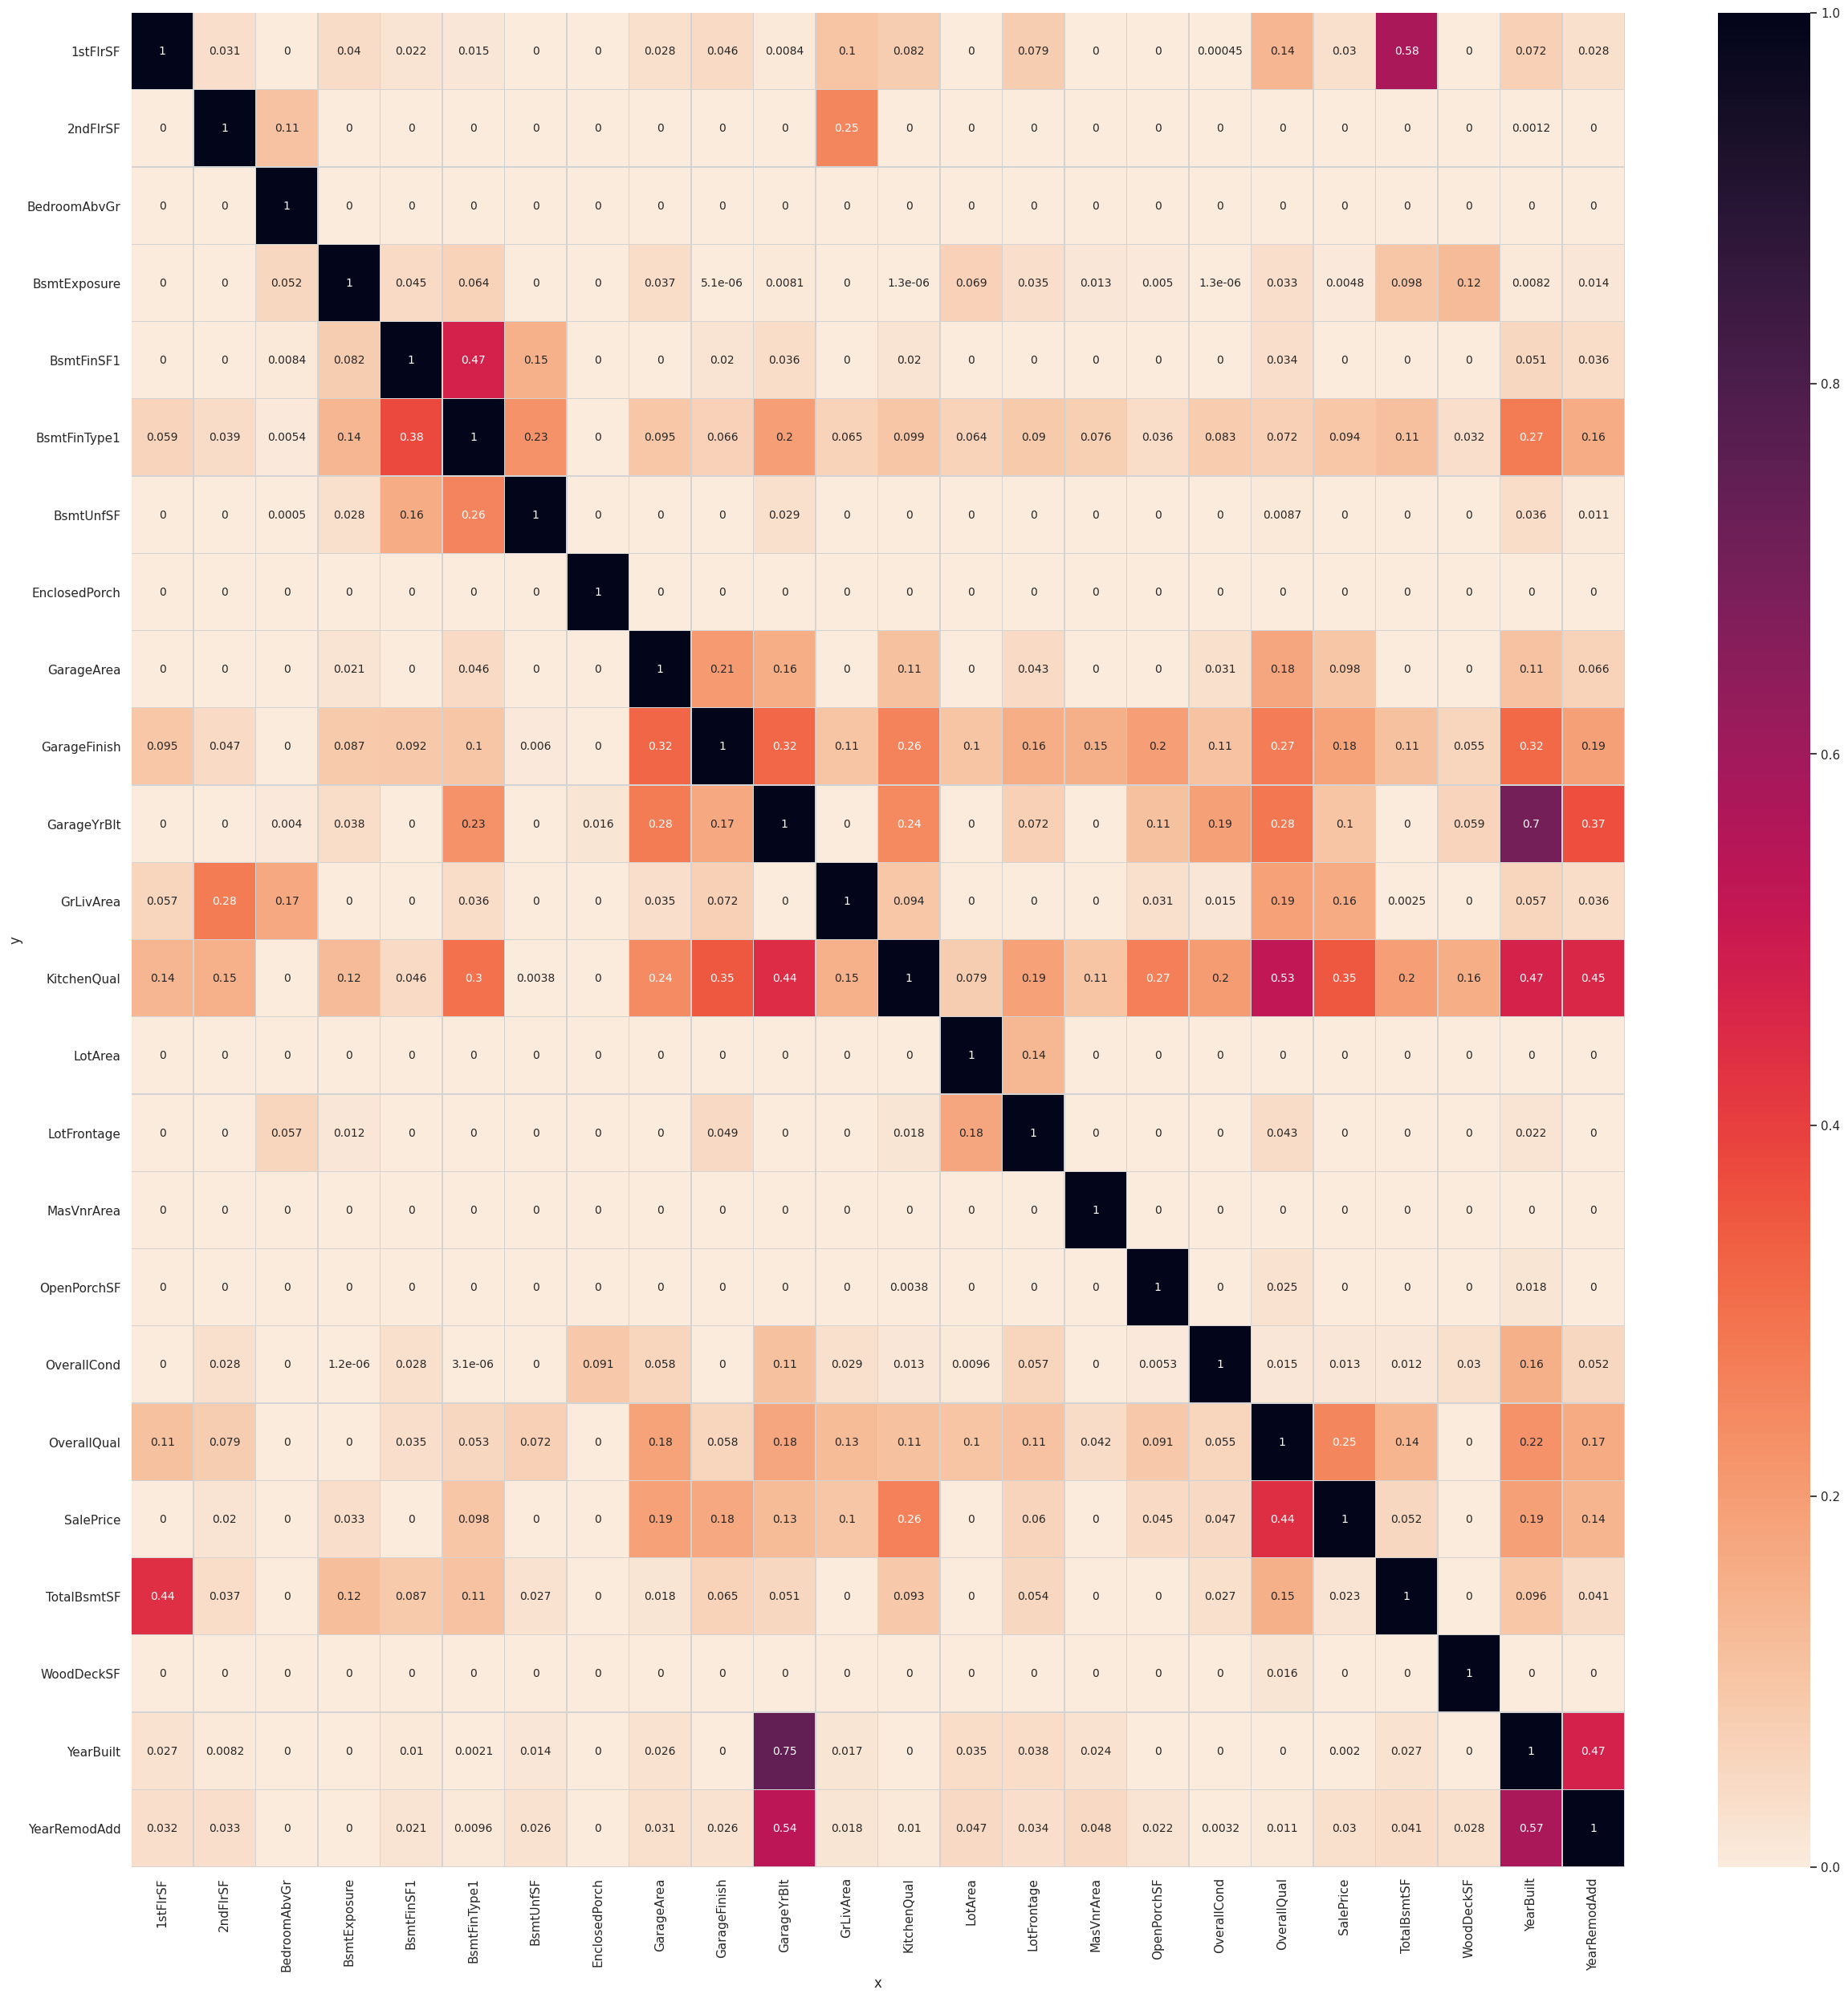

In [48]:
heatmap_pps(df=pps_matrix, threshold=0)

In [49]:
pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T

,count,mean,std,min,25%,50%,75%,max
ppscore,552.0,0.053461,0.10376,0.0,0.0,0.0,0.058438,0.746144


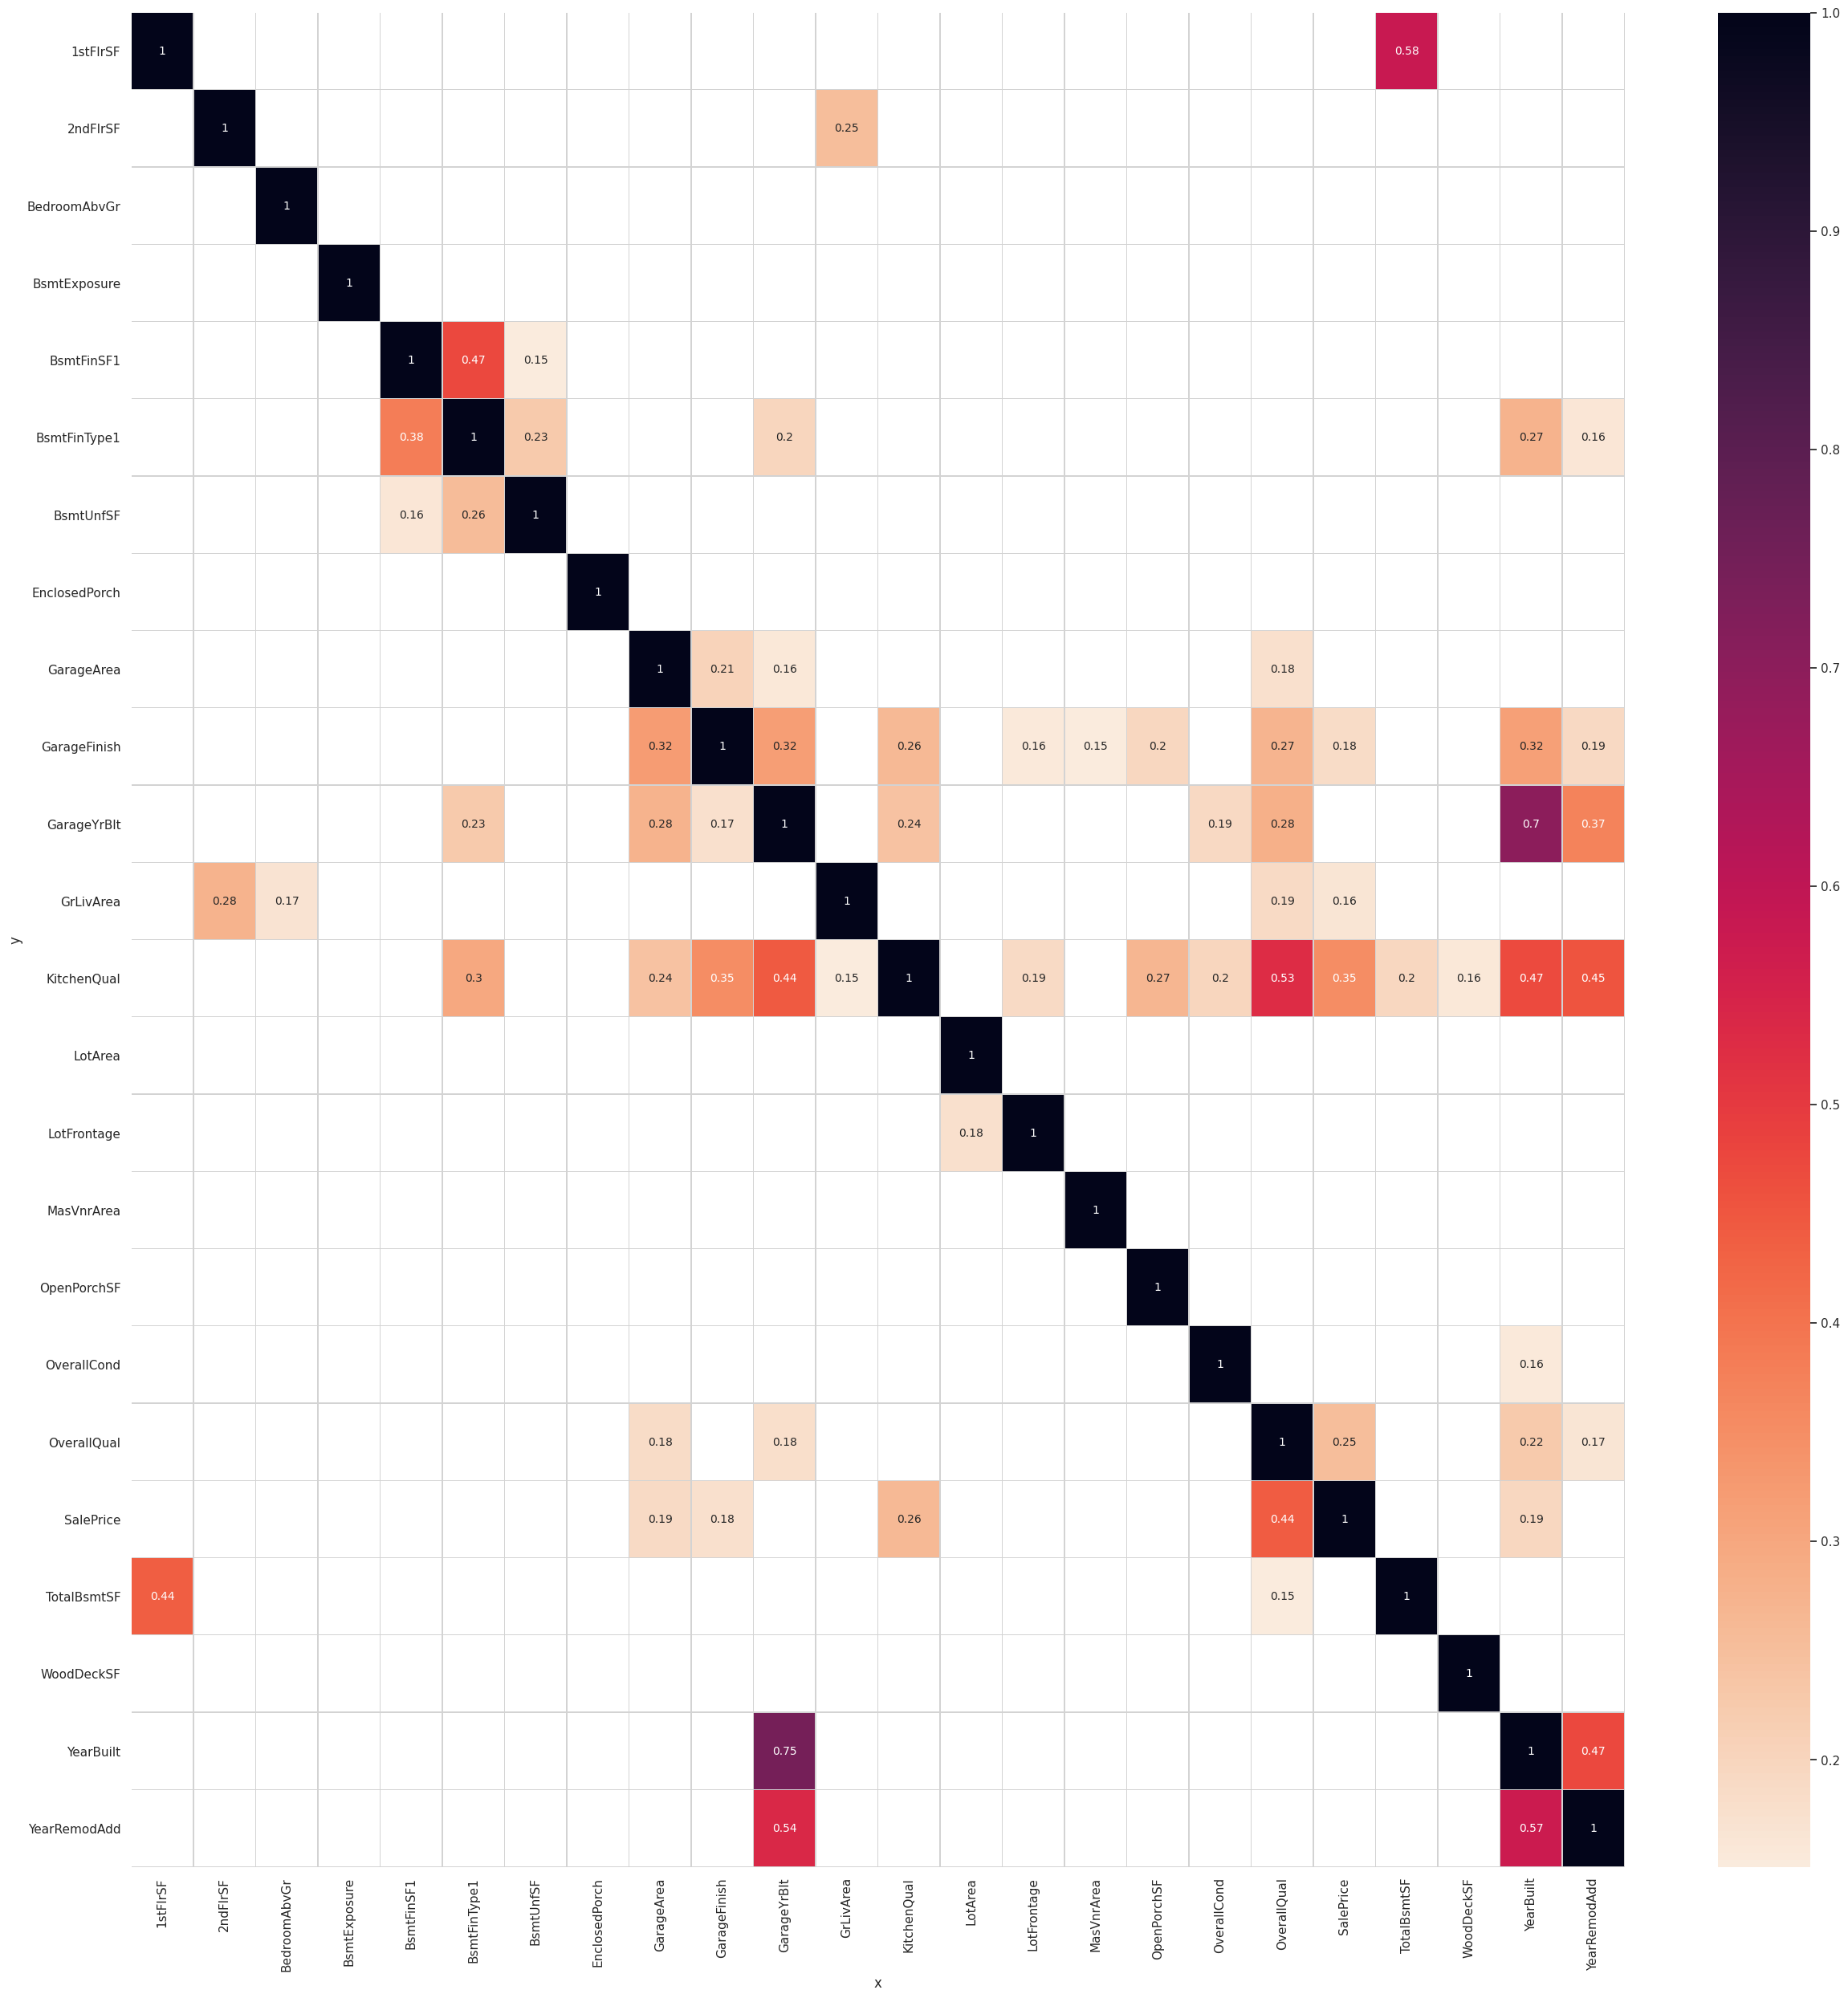

In [53]:
# IQR range is 0-0.58 , so a threshold is set just above to see which variables have predictive power

heatmap_pps(df=pps_matrix, threshold=0.15)

It looks like the ```['GarageArea','GarageFinish','KitchenQual','OverallQual','YearBuilt']``` can hold predictive power over ```SalePrice```. 

```OverallQual``` have better predicting power and others have somewhat weak predictive power. Let's have a look at them one by one, to see if we can spot any patterns.

**Garage Area**

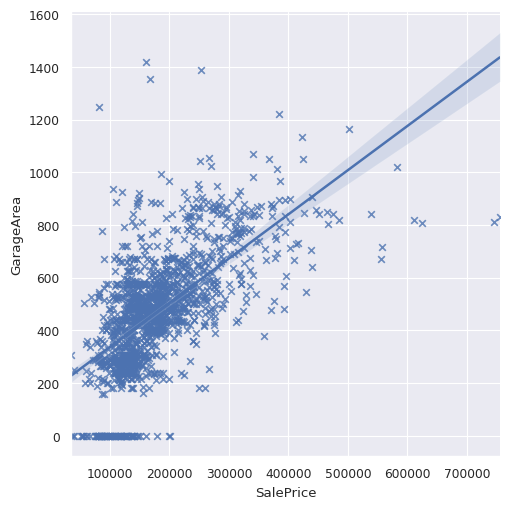

In [77]:
sns.set_theme()
sns.set_context('paper')
sns.lmplot(
    data=df,
    x="SalePrice", y="GarageArea",markers='x'
)

Typically, sales prices increases with garage area.

**Kitchen Quality**

/workspace/.pip-modules/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 50.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/workspace/.pip-modules/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 70.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


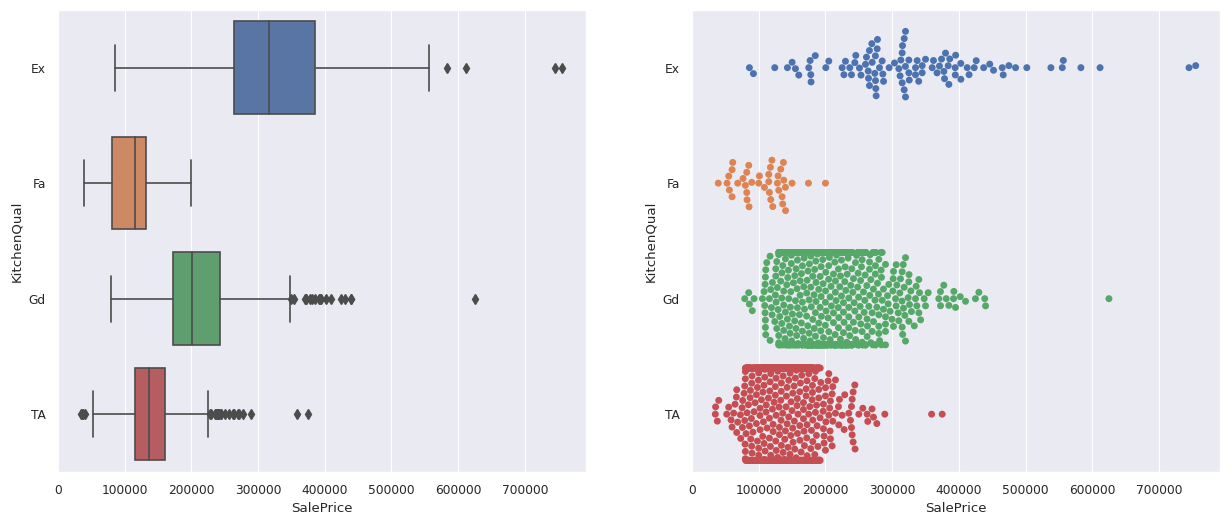

In [81]:
var_list = ['KitchenQual']#,'OverallQual'] #,'GarageFinish','KitchenQual','OverallQual','YearBuilt']
for col in var_list:

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
  sns.boxplot(data=df, y=col, x='SalePrice', ax=axes[0])
  sns.swarmplot(data=df, y=col, x='SalePrice', dodge=True, ax=axes[1])
  plt.show()

There is not much relationship between kitchen quality and sales prices.

**Overall Quality**

/workspace/.pip-modules/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 58.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/workspace/.pip-modules/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 81.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/workspace/.pip-modules/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 76.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/workspace/.pip-modules/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 69.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/workspace/.pip-modules/lib/python3.8/site-packages/seaborn/categori

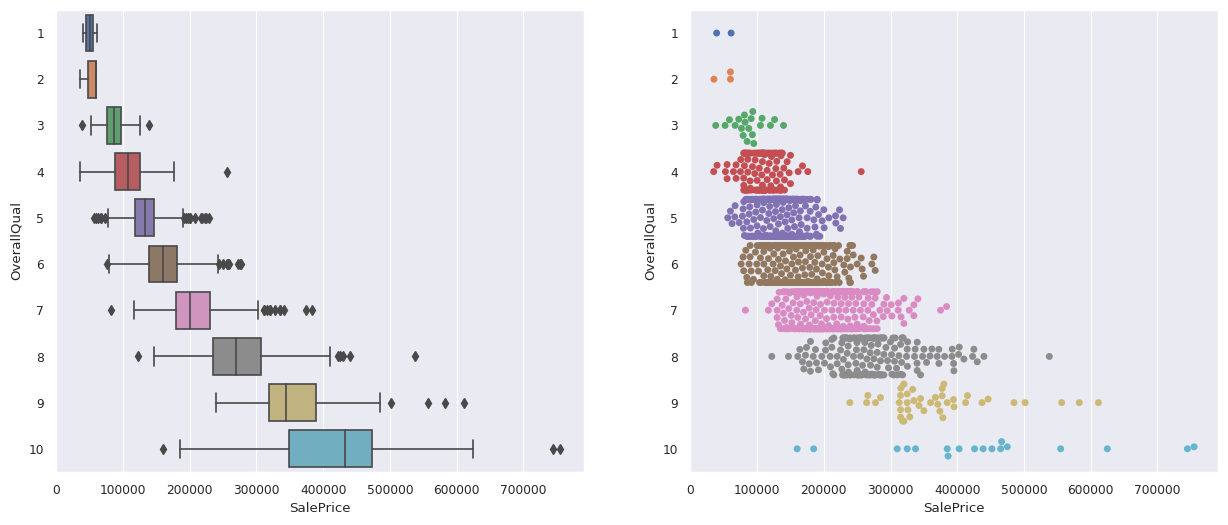

In [82]:
var_list = ['OverallQual']#,'OverallQual'] #,'GarageFinish','KitchenQual','OverallQual','YearBuilt']
for col in var_list:

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
  sns.boxplot(data=df, y=col, x='SalePrice', ax=axes[0])
  sns.swarmplot(data=df, y=col, x='SalePrice', dodge=True, ax=axes[1])
  plt.show()

There is a clear trend, where increase in quality lead to increase in sale price. The trend is obvious and realistic of physical world.

**Year Built**

In [86]:
# subset data and sort it by year

df_subset=df[['SalePrice','YearBuilt']].sort_values(by='YearBuilt')
df_subset

,SalePrice,YearBuilt
1349,122000,1872
1137,94000,1875
747,265979,1880
304,295000,1880
1132,117500,1880
...,...,...
898,611657,2009
515,402861,2009
157,269500,2009
762,215200,2009


Looks like treating YearsBuilt as categorical data is not helping. So, let's convert it back to numerical

In [93]:
df['YearBuilt']=df['YearBuilt'].astype('float64')
df.dtypes

1stFlrSF            int64
2ndFlrSF          float64
BedroomAbvGr      float64
BsmtExposure     category
BsmtFinSF1          int64
BsmtFinType1     category
BsmtUnfSF           int64
EnclosedPorch     float64
GarageArea          int64
GarageFinish     category
GarageYrBlt       float64
GrLivArea           int64
KitchenQual      category
LotArea             int64
LotFrontage       float64
MasVnrArea        float64
OpenPorchSF         int64
OverallCond      category
OverallQual      category
TotalBsmtSF         int64
WoodDeckSF        float64
YearBuilt         float64
YearRemodAdd     category
SalePrice           int64
dtype: object

In [96]:
bins=np.arange(start=1870,stop=2010,step=10)

bins

array([1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970,
       1980, 1990, 2000])